# **Diagnóstico Automatizado de Linfomas Malignos en Biopsias H&E mediante Aprendizaje Automático**
## *Aftab Ahmed Choudhry*

In [1]:
from PIL import Image
import os
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## ***Conversión Única de Imágenes .tif a .png***

Esta celda se ejecuta **una sola vez** para convertir las imágenes originales descargadas desde Kaggle (en formato `.tif`) al formato `.png`, ya que `image_dataset_from_directory()` de TensorFlow **no soporta `.tif`**. Tras la conversión, las imágenes `.tif` se eliminan automáticamente.

In [2]:
base_path = './dataset'

for class_name in ['CLL', 'FL', 'MCL']:
    folder = os.path.join(base_path, class_name)
    tif_files = glob.glob(os.path.join(folder, '*.tif'))
    png_files = glob.glob(os.path.join(folder, '*.png'))

    if len(png_files) > 0:
        print(f"Conversión ya realizada para la clase {class_name}. Se omite.")
        continue

    for tif_path in tif_files:
        with Image.open(tif_path) as img:
            rgb_img = img.convert('RGB')
            new_path = tif_path.replace('.tif', '.png')
            rgb_img.save(new_path)

        os.remove(tif_path)
    
    print(f"Conversión completada para la clase {class_name}.")

Conversión ya realizada para la clase CLL. Se omite.
Conversión ya realizada para la clase FL. Se omite.
Conversión ya realizada para la clase MCL. Se omite.


## *Verificación de disponibilidad de GPU*

Esta celda comprueba si TensorFlow detecta una GPU en el entorno actual. Es útil para confirmar que la aceleración por hardware está activa y que se aprovechará la GPU durante el entrenamiento del modelo.

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## Preproceso

### Carga de los datos

In [4]:
dataset_path = './dataset'
image_size = (1388, 1040)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size = image_size,
    shuffle = True,
    seed = 23,
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 374 files belonging to 3 classes.
Classes: ['CLL', 'FL', 'MCL']


### Visualización básica

In [ ]:
'''
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()} ({class_names[labels[i].numpy()]})")
        plt.axis("off")

### Partición del conjunto de datos

In [5]:
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 1388, 1040, 3), (75, 1388, 1040, 3), (299,), (75,))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=23, stratify=y_train)

print("Train:", X_train.shape, y_train.shape)
print("Validation:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (269, 1388, 1040, 3) (269,)
Validation:   (30, 1388, 1040, 3) (30,)
Test:  (75, 1388, 1040, 3) (75,)


In [ ]:
'''
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
df_train = pd.DataFrame(X_train_flattened)
df_train['target'] = y_train
df_train.head()

Reordenaremos las columnas de manera que la variable target sea la primera

In [ ]:
'''
cols = list(df_train.columns)
cols.remove('target')
cols.insert(0,'target')
df_train = df_train.reindex(columns=cols)
df_train.head()

In [ ]:
#df_train.iloc[:, :1000].describe().T

In [ ]:
#df_train['target'].value_counts()

In [7]:
def resize_images(X):
    resized = []
    
    for img in X:
        img_resized = tf.image.resize(img, (299, 299))
        resized.append(img_resized.numpy())
        
    return np.array(resized)

In [8]:
X_train = resize_images(X_train)
X_val = resize_images(X_val)
X_test = resize_images(X_test)

X_train.shape, X_val.shape, X_test.shape

((269, 299, 299, 3), (30, 299, 299, 3), (75, 299, 299, 3))

In [9]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

## Entrenar la CNN

### InceptionV3

In [10]:
base_model = InceptionV3(include_top = False)
base_model.trainable = False
inputs = Input(shape=(299, 299, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation = 'softmax')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
'''
tf.keras.utils.plot_model(
    base_model,
    to_file = 'InceptionV3.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    dpi = 100
)

In [11]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [12]:
EPOCHS = 30
callbacks = [ReduceLROnPlateau(monitor = 'val_accuracy', patience = 4, factor = 0.1, verbose = 1, min_lr = 1e-6),
             EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1)]

In [13]:
history = model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))

Epoch 1/30
9/9 [==============================] - 11s 377ms/step - loss: 1.1850 - accuracy: 0.4201 - val_loss: 1.1533 - val_accuracy: 0.3333
Epoch 2/30
9/9 [==============================] - 2s 182ms/step - loss: 1.0673 - accuracy: 0.4201 - val_loss: 1.1550 - val_accuracy: 0.3667
Epoch 3/30
9/9 [==============================] - 2s 181ms/step - loss: 0.9352 - accuracy: 0.5390 - val_loss: 1.0830 - val_accuracy: 0.4333
Epoch 4/30
9/9 [==============================] - 2s 181ms/step - loss: 0.8700 - accuracy: 0.6022 - val_loss: 1.0623 - val_accuracy: 0.4667
Epoch 5/30
9/9 [==============================] - 2s 183ms/step - loss: 0.8308 - accuracy: 0.6468 - val_loss: 1.0449 - val_accuracy: 0.4667
Epoch 6/30
9/9 [==============================] - 2s 181ms/step - loss: 0.7585 - accuracy: 0.7026 - val_loss: 1.0020 - val_accuracy: 0.5000
Epoch 7/30
9/9 [==============================] - 2s 181ms/step - loss: 0.7239 - accuracy: 0.7175 - val_loss: 0.9619 - val_accuracy: 0.5333
Epoch 8/30
9/9 [===

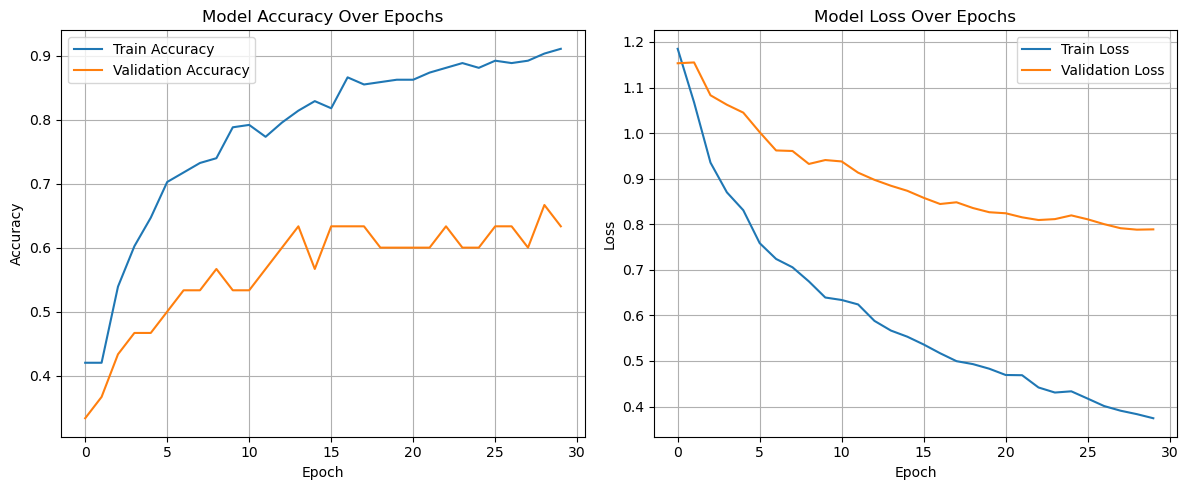

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()